# Week 3: Lightcurves of HAT-P-11b and KELT-9b
For each of the exoplanets HAT-P-11b and KELT-9b, I will 
- Use `lightkurve` to create a plot of the standard TESS 2-min data.
- Also using `lightkurve`, create a plot of the lightcurve using Simple Aperture Photometry (SAP) from the 2-min data.
- Create another SAP lightcurve using a different aperture, such as the entire image
- Create a lightcurve using eleanor with the 30-min FFI data, experimenting with different apertures in the 30-min data.

This notebook was made by Jack Dinsmore on June 8th. The lightcurves can be compared with those provided by [exo.MAST](https://exo.mast.stsci.edu/exomast_planet.html?planet=KELT9b).

### Questions

Permanent questions:
- Why does my KELT-9b `lightkurve` lightcurve look so bad? This is connected to the pixel file choice.
- How do people normally pick which quarter / sector of data to use?
- What does PLD stand for (it's the name of an error correction algorithm that `lightkurve` has implemented for TESS)? Is it the same as PSF?
- How do you choose which pixel file to download? The best quality? Or do you use all of them?

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import lightkurve as lk
import numpy as np

PLANETS = ["HAT-P-11b", "KELT-9b"]

## 1. Plot the standard TESS 2-min data
We can download the light curve from the TESScut database and extract it as follows. First, we need to download the fits files.

In [36]:
lcfs = [lk.search_lightcurvefile(p).download() for p in PLANETS]

Next, we need to plot the lightcurves.

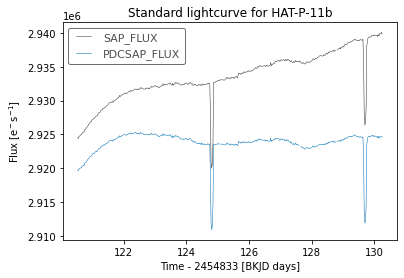

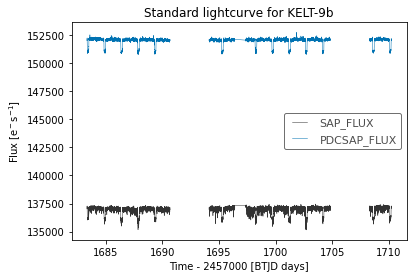

In [4]:
for i in range(len(lcfs)):
    fig, ax = plt.subplots()
    lcfs[i].plot(ax=ax)
    ax.set_title("Standard lightcurve for {0}".format(PLANETS[i]))

## 2. Plot the TESS 2-min data with SAP

Download our planets' pixelfiles so we can see their lightcurves and display the star. Each star has multiple runs of data that could be used, I have manually looked through and picked some that look good.

In [38]:
searchResults = [lk.search_targetpixelfile(p) for p in PLANETS]
print([len(sr) for sr in searchResults])
print(searchResults)

searchIndex = [15, 1]# for the first one, 16 sucks, but 1 is great.

pixelfiles = [searchResults[i][searchIndex[i]].download(quality_bitmask='hardest') for i in range(len(PLANETS))]

[17, 2]
[SearchResult containing 17 data products.

 #     observation     target_name                      productFilename                     distance
--- ----------------- ------------- ------------------------------------------------------- --------
  0  Kepler Quarter 0 kplr010748390            kplr010748390-2009131105131_lpd-targ.fits.gz      0.0
  1  Kepler Quarter 1 kplr010748390            kplr010748390-2009166043257_lpd-targ.fits.gz      0.0
  2  Kepler Quarter 2 kplr010748390            kplr010748390-2009259160929_lpd-targ.fits.gz      0.0
  3  Kepler Quarter 3 kplr010748390            kplr010748390-2009350155506_lpd-targ.fits.gz      0.0
  4  Kepler Quarter 4 kplr010748390            kplr010748390-2010078095331_lpd-targ.fits.gz      0.0
  5  Kepler Quarter 5 kplr010748390            kplr010748390-2010174085026_lpd-targ.fits.gz      0.0
  6  Kepler Quarter 6 kplr010748390            kplr010748390-2010265121752_lpd-targ.fits.gz      0.0
  7  Kepler Quarter 8 kplr010748390    

Later on, we will correct the lightcurves by subtracting background noise. In order to do this for HAT-P-11b, we need a rectangular image. In its current state, the image is circular, so we trim it a bit. Then we display the stars.

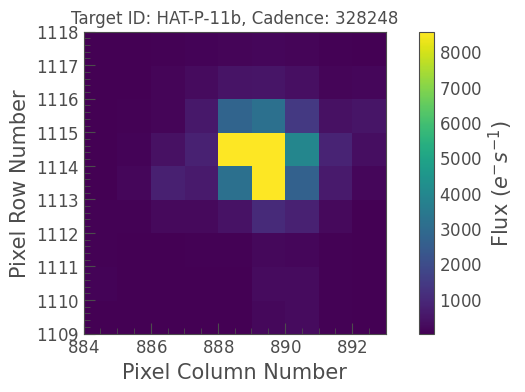

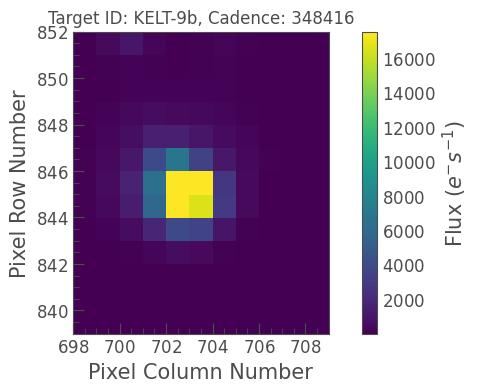

In [41]:
# Trim the HAT-P-11b picture
index = PLANETS.index("HAT-P-11b")
#pixelfiles[index] = pixelfiles[index].cutout(size=(pixelfiles[index].shape[1]-6, pixelfiles[index].shape[2]-2))
#print(pixelfiles[index].shape)
#pixelfiles[index] = pixelfiles[index].cutout(center=(6, 9), size=(10, 16))

for i in range(len(PLANETS)):
    
    plot = pixelfiles[i].plot(frame=1)
    cadenceIndex = plot.get_title().find(',')
    plot.set_title("Target ID: " + PLANETS[i] + plot.get_title()[cadenceIndex:]);

Now we will get the aperture mask suggested by the lightkurve pipeline and make sure it is reasonable

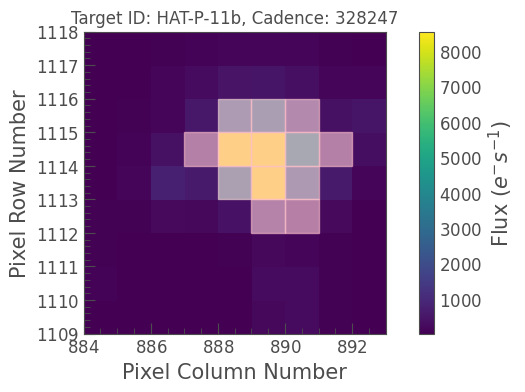

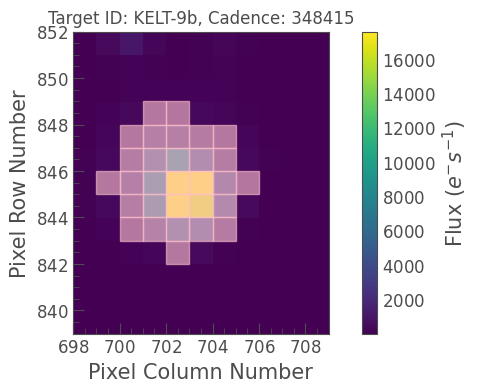

In [42]:
aper = [pf.create_threshold_mask() for pf in pixelfiles];
for i in range(len(PLANETS)):
    p = pixelfiles[i].plot(aperture_mask=aper[i]);
    cadenceIndex =p.get_title().find(',')
    p.set_title("Target ID: " + PLANETS[i] + p.get_title()[cadenceIndex:]);

Now we can access the lightcurves associated with these aperture masks.

In [43]:
lightcurves = [pixelfiles[i].to_lightcurve(aperture_mask=aper[i]).flatten() for i in range(len(PLANETS))];

If we wanted to, we would clean the data. There are a few ways to do this, and the `lightkurve` methods are listed [here](https://docs.lightkurve.org/tutorials/index.html#removing-instrument-noise). I started by removing the background noise from reflected light, but this became a problem because the pixel file for HAT-P-11b is not square, and the algorithm assumes it is square. I have not fixed this problem, so I just flattened the curve instead. Code is below.

In [46]:
correctedLCs = []
CORRECT_MODE = "pca"

NUMBER_PCA_COMPONENTS = 2# Supposed to be "much smaller than the" number of stars on the CCD.
    # Originally 5

if CORRECT_MODE == "pca": #(aperture * TPF + background subtraction + cotrending basis vectors)
    regressors = [pixelfiles[i].flux[:, ~aper[i]] for i in range(len(PLANETS))]# The regressor is the inverse of the aperture

    dms = [lk.DesignMatrix(r, name='regressors').pca(NUMBER_PCA_COMPONENTS).append_constant() for r in regressors]
    correctors = [lk.RegressionCorrector(lc) for lc in lightcurves]
    correctedLCs = [correctors[i].correct(dms[i]) for i in range(len(PLANETS))]
    
if CORRECT_MODE == "pld":# Don't know what this is, but I think it's similar to PSF.
    from lightkurve.correctors import TessPLDCorrector
    correctors = [TessPLDCorrector(pf) for pf in pixelfiles]
    correctedLCs = [c.correct() for c in correctors]

Now we will plot our corrected lightcurves.

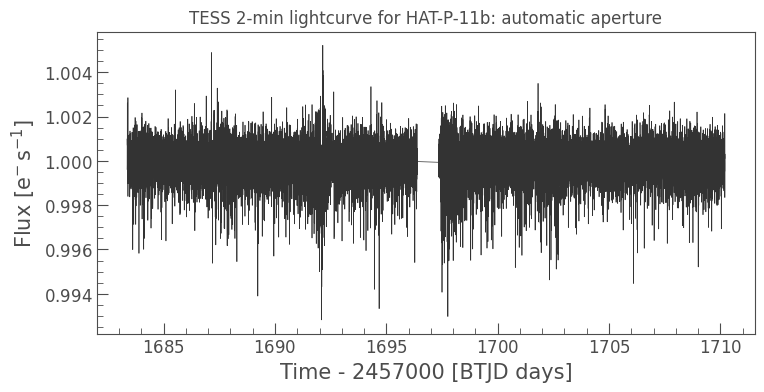

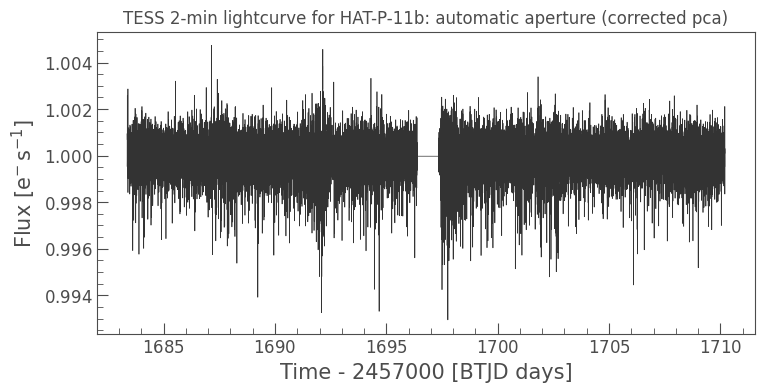

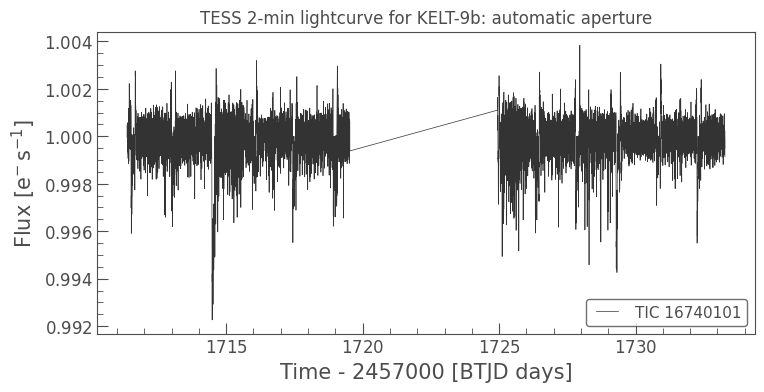

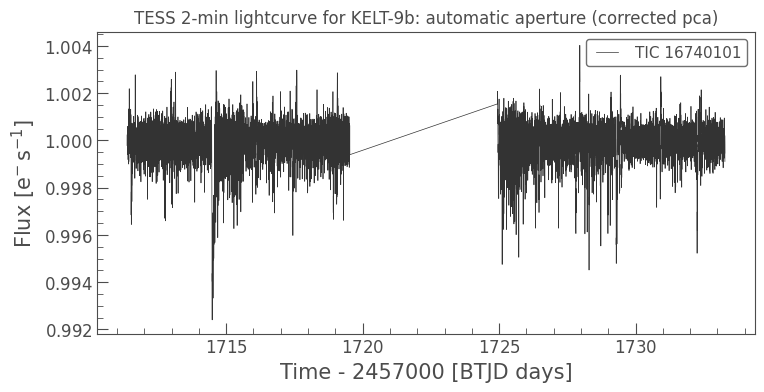

In [47]:
for i in range(len(PLANETS)):
    plot = lightcurves[i].plot();
    plot2 = correctedLCs[i].flatten().plot();
    plot.set_title("TESS 2-min lightcurve for {0}: automatic aperture".format(PLANETS[i]));
    plot2.set_title("TESS 2-min lightcurve for {0}: automatic aperture (corrected {1})".format(PLANETS[i], CORRECT_MODE));

## 3. Plot the TESS 2-min data with a different aperture
To demonstrate using a custom aperture, I will use the entire image, removing no pixels. All we need to do is repeat some of the code from above:

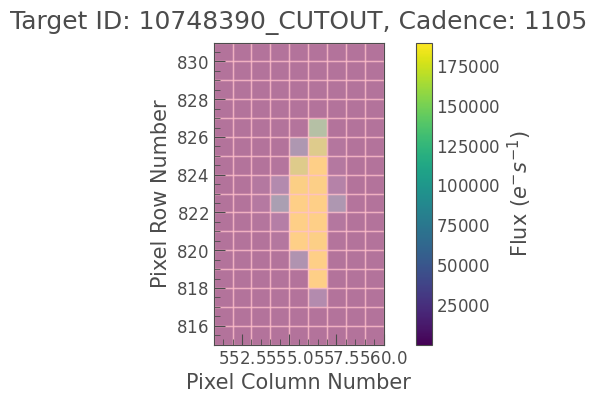

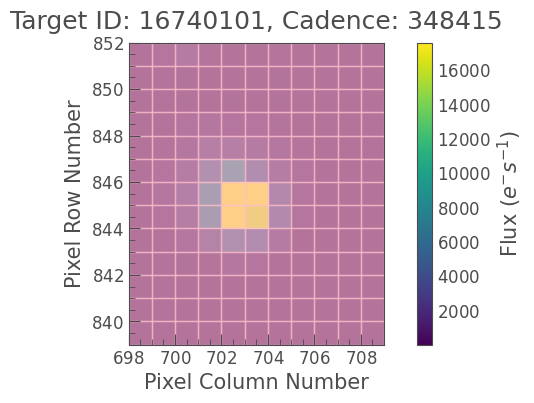

In [11]:
newAper = [np.ones_like(a) for a in aper];
for i in range(len(PLANETS)):
    pixelfiles[i].plot(aperture_mask=newAper[i]);

Now we make and plot the lightcurves:

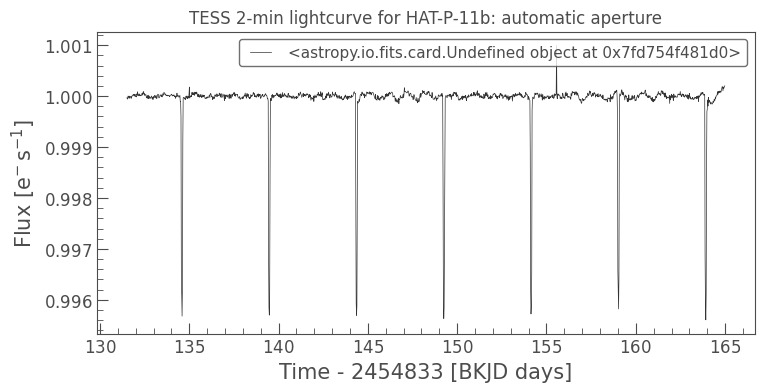

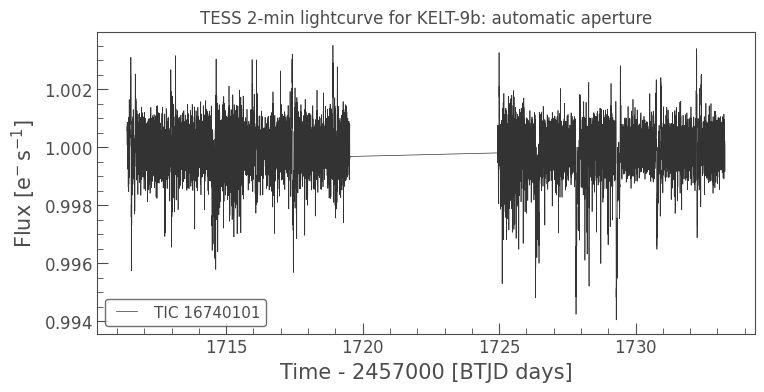

In [12]:
lightcurves = [pixelfiles[i].to_lightcurve(aperture_mask=newAper[i]).flatten() for i in range(len(PLANETS))];

for i in range(len(PLANETS)):
    plot = lightcurves[i].plot();
    plot.set_title("TESS 2-min lightcurve for {0}: automatic aperture".format(PLANETS[i]));

We could have skipped the first step by simply setting the `aperture_mask` flag in `to_lightcurve` equal to `'all'`, but I didn't because I wanted the picture and the ability to set the aperture more directly.

There new aperture doesn't cause a huge difference in the lightcurves, probably because the star is a significant fraction of the image and there are no background stars. But you can tell that the lightcurves made with a bigger aperture are lower quality because of noise from potential background stars and because the data is diluted

## 4. Eleanor lightcurve with 30-min FFI data
I'm using code very similar to the tutorial code in _WASP-100-b-analysis.ipynb_. First, we need to access the TESS data for the stars.

In [13]:
from IPython.display import Image
import eleanor
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord

import warnings
warnings.filterwarnings('ignore')

stars = [eleanor.Source(name=p) for p in PLANETS]

No eleanor postcard has been made for your target (yet). Using TessCut instead.
No eleanor postcard has been made for your target (yet). Using TessCut instead.


Then, we need to get the target data...

In [14]:
data = [eleanor.TargetData(s, height=15, width=15, bkg_size=31, do_psf=True, do_pca=True) for s in stars]

100%|██████████| 1197/1197 [00:18<00:00, 63.60it/s]


... and display the lightcurves. Plotted below are the following:
- Black : the raw light curve (aperture $\times$ TPF + background subtraction)
- Red : the corrected light curve (black light curve + additional corrections)
- Green : the PCA light curve (aperture $\times$ TPF + background subtraction + cotrending basis vectors)
- Blue : the PSF modeled light curve

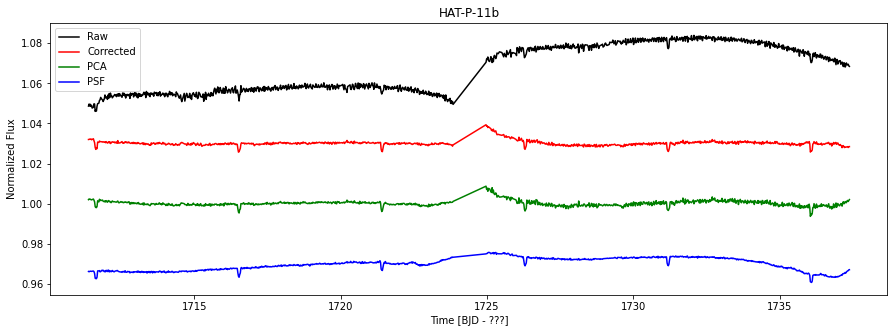

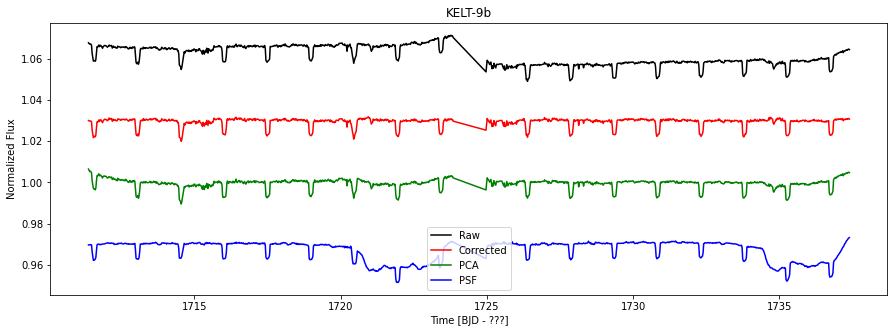

In [15]:
for i in range(len(data)):
    plt.figure(figsize=(15,5))

    q = data[i].quality == 0
    plt.plot(data[i].time[q], data[i].raw_flux[q]/np.nanmedian(data[i].raw_flux[q])+0.06, 'k', label='Raw')
    plt.plot(data[i].time[q], data[i].corr_flux[q]/np.nanmedian(data[i].corr_flux[q]) + 0.03, 'r', label='Corrected')
    plt.plot(data[i].time[q], data[i].pca_flux[q]/np.nanmedian(data[i].pca_flux[q]), 'g', label='PCA')
    plt.plot(data[i].time[q], data[i].psf_flux[q]/np.nanmedian(data[i].psf_flux[q]) - 0.03, 'b', label='PSF')
    plt.ylabel('Normalized Flux')
    plt.xlabel('Time [BJD - ???]')# Used to be BJD - 2457000, but I don't know if that's tutorial-specific
    plt.legend()
    plt.title(PLANETS[i]);

If we wanted, we could choose a custom aperture. We can set it as shown below.

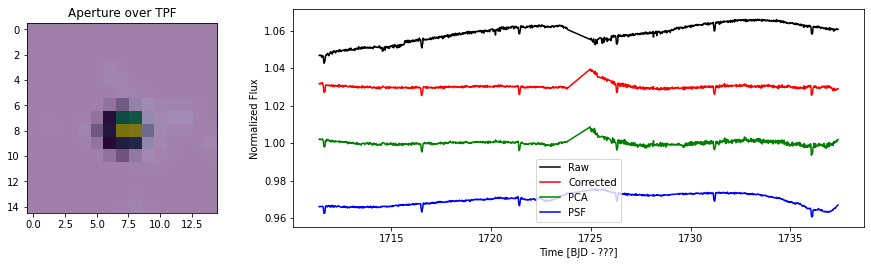

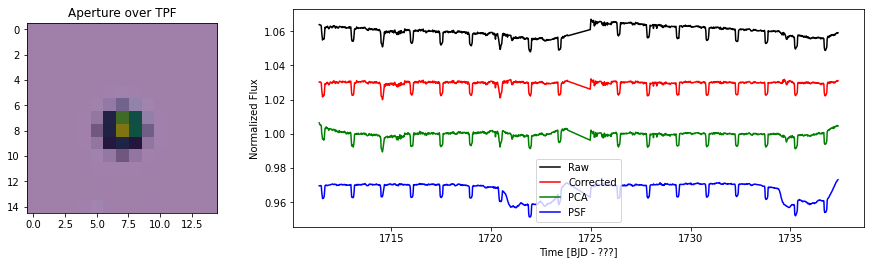

In [16]:
SHAPES = ["circle", "circle"]
RADII = [2, 2]
POSES = [(7, 8), (7, 8)]

for i in range(len(PLANETS)):
    eleanor.TargetData.custom_aperture(data[i], shape=SHAPES[i], r=RADII[i], pos=POSES[i], method='exact')
    eleanor.TargetData.get_lightcurve(data[i])

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
    ax1.imshow(data[i].tpf[0])
    ax1.imshow(data[i].aperture, cmap='Greys', alpha=0.5)
    ax1.set_title('Aperture over TPF')

    #ax2.plot(data[i].time[q], data[i].raw_flux[q]/np.nanmedian(data[i].raw_flux[q]), 'k', label='Raw')
    #ax2.plot(data[i].time[q], data[i].corr_flux[q]/np.nanmedian(data[i].corr_flux[q]) - 0.035, 'r', label='Corrected')
    
    ax2.plot(data[i].time[q], data[i].raw_flux[q]/np.nanmedian(data[i].raw_flux[q])+0.06, 'k', label='Raw')
    ax2.plot(data[i].time[q], data[i].corr_flux[q]/np.nanmedian(data[i].corr_flux[q]) + 0.03, 'r', label='Corrected')
    ax2.plot(data[i].time[q], data[i].pca_flux[q]/np.nanmedian(data[i].pca_flux[q]), 'g', label='PCA')
    ax2.plot(data[i].time[q], data[i].psf_flux[q]/np.nanmedian(data[i].psf_flux[q]) - 0.03, 'b', label='PSF')
    
    ax2.legend()
    ax2.set_xlabel('Time [BJD - ???]')
    ax2.set_ylabel('Normalized Flux');

We could even set the aperture pixel by pixel using a method similar to the one we used in section 3. But this is faster.